# 0. Introduction:
The purpose of this notebook is to apply to machine learning techniques taught in the **fastai** *Introduction to Machine Learning for Coders (2018)* MOOC. The course is a fantastic resource for learning about random forests, their strengths and weaknesses, and how to use them to extract insights. 

In [1]:
!pip install treeinterpreter

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import collections
import scipy
import math
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *
from treeinterpreter import treeinterpreter as ti
from sklearn.model_selection import GridSearchCV

#to show all columns when we display a dataframe
pd.set_option('display.max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/train.csv


# 1. Data Exploration & Cleaning:
## 1.1 Compile Training / Test Sets:
The first step in this process is to import data, and combine the training and test set for data pre-processing.

In [3]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
df = pd.concat([train, test])
print('Training set size: ',train.shape,'\nTest set size: ',test.shape,'\nCombined set size: ',df.shape)
assert train.shape[0] + test.shape[0] == df.shape[0]

Training set size:  (1460, 81) 
Test set size:  (1459, 80) 
Combined set size:  (2919, 81)


In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


We can find the target feature by finding out which column(s) exist in the training set, but not in the test set:

In [5]:
#list comprehension to determine the target variable
unique_vars = [x for x in list(train.columns) if x not in list(test.columns)]
unique_vars

['SalePrice']

In [6]:
#see high level statistical summary of the training set
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
#see high level statistical summary of the test set
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


With so many columns/features, it can be difficult to glean useful information from the describe() method. 
## 1.2 Identify Missing Data:
We must determine what data is missing, and devise an appropriate solution to replace missing data with appropriate substitude values. 

In [8]:
#Determine amount of missing information in training set
missing_training = pd.DataFrame(train.isna().sum(),columns=['missing'])
missing_training[missing_training.missing != 0],\
print('Features with missing data: ',len(missing_training[missing_training.missing != 0]))

Features with missing data:  19


(              missing
 LotFrontage       259
 Alley            1369
 MasVnrType          8
 MasVnrArea          8
 BsmtQual           37
 BsmtCond           37
 BsmtExposure       38
 BsmtFinType1       37
 BsmtFinType2       38
 Electrical          1
 FireplaceQu       690
 GarageType         81
 GarageYrBlt        81
 GarageFinish       81
 GarageQual         81
 GarageCond         81
 PoolQC           1453
 Fence            1179
 MiscFeature      1406,
 None)

In [9]:
#Determine amount of missing information in test set
missing_test = pd.DataFrame(test.isna().sum(),columns=['missing'])
missing_test[missing_test.missing != 0],\
print('Features with missing data: ',len(missing_test[missing_test.missing != 0]))

Features with missing data:  33


(              missing
 MSZoning            4
 LotFrontage       227
 Alley            1352
 Utilities           2
 Exterior1st         1
 Exterior2nd         1
 MasVnrType         16
 MasVnrArea         15
 BsmtQual           44
 BsmtCond           45
 BsmtExposure       44
 BsmtFinType1       42
 BsmtFinSF1          1
 BsmtFinType2       42
 BsmtFinSF2          1
 BsmtUnfSF           1
 TotalBsmtSF         1
 BsmtFullBath        2
 BsmtHalfBath        2
 KitchenQual         1
 Functional          2
 FireplaceQu       730
 GarageType         76
 GarageYrBlt        78
 GarageFinish       78
 GarageCars          1
 GarageArea          1
 GarageQual         78
 GarageCond         78
 PoolQC           1456
 Fence            1169
 MiscFeature      1408
 SaleType            1,
 None)

In [10]:
#list comprehension to determine features that are missing information in the test set, but not in the training set
missing_vars_in_test = [x for x in list(missing_test[missing_test.missing != 0].index) \
                        if x not in list(missing_training[missing_training.missing != 0].index)]
missing_vars_in_test, print('Features missing in test set, but not in training set: ',len(missing_vars_in_test))

Features missing in test set, but not in training set:  15


(['MSZoning',
  'Utilities',
  'Exterior1st',
  'Exterior2nd',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  'BsmtFullBath',
  'BsmtHalfBath',
  'KitchenQual',
  'Functional',
  'GarageCars',
  'GarageArea',
  'SaleType'],
 None)

## 1.3 Check for Temporal Difference between Training/Test Sets:
Another consideration when dealing with price predictions is whether or not there is a temporal aspect to the problem at hand. Often with price predictions, the training set will be on historical sales data, and the objective is to create a model that can predict future sales prices. This means we would test our model on sales later in time, so we would need to select a validation set that mimics this difference in time.

For this specific Kaggle competition, we can see that the time range in the training set is the same as the test set. Since we are training on sales data between 2006 - 2010, and also predicting sales between 2006 - 2010, there is no need to build a model that looks forward in time to make predictions.

In [11]:
#check time range of house sales in training/test set to determine if there is a temporal aspect to the problem
print(f'Training Set YrSold Range: {train.YrSold.min()} - {train.YrSold.max()}')
print(f'Test Set YrSold Range: {test.YrSold.min()} - {test.YrSold.max()}')

Training Set YrSold Range: 2006 - 2010
Test Set YrSold Range: 2006 - 2010


## 1.4 Identify Feature Types:
We must separate numeric features from non-numeric features. Numeric features can be further subdivided into continuous features and categorical features, while non-numeric features must (in the majority of cases) be categorical.

First, we separate the numeric features from the non-numeric features.

In [12]:
def find_numerical_vars(df):
    """Separate numerical and non-numerical features for a dataset by creating two separate lists."""
    
    non_numeric_cols = [col for col in list(df.columns) if df[col].dtype != 'int64' and df[col].dtype != 'float64']
    numeric_cols = [col for col in list(df.columns) if col not in non_numeric_cols]
    return non_numeric_cols, numeric_cols

#call the function and create lists of numeric and non-numeric features
non_numeric_cols, numeric_cols = find_numerical_vars(df)

#remove the target variable from the list of numeric features
numeric_cols.remove('SalePrice')

Then, we separate the numeric features into continuous and categorical features.

In [13]:
def split_num_feats(df,numeric_cols):
    """Create new lists of categorical and continuous numerical features for all the numeric columns in a dataset.
    Features with less than 20 unique items are classified as categorical."""
    
    cont_num_feats = []
    cat_num_feats = []
    
    for col in numeric_cols:
        if len(set(df[col])) <= 20:
            print(f'Categories in {col} feature: {set(df[col])}\n')
            cat_num_feats.append(col)
        else:
            print(f'{col} is a continuous feature')
            cont_num_feats.append(col)
    return cont_num_feats, cat_num_feats

cont_num_cols, cat_num_cols = split_num_feats(df, numeric_cols)

Id is a continuous feature
Categories in MSSubClass feature: {160, 70, 40, 75, 45, 80, 50, 20, 85, 180, 30, 120, 150, 90, 60, 190}

LotFrontage is a continuous feature
LotArea is a continuous feature
Categories in OverallQual feature: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

Categories in OverallCond feature: {1, 2, 3, 4, 5, 6, 7, 8, 9}

YearBuilt is a continuous feature
YearRemodAdd is a continuous feature
MasVnrArea is a continuous feature
BsmtFinSF1 is a continuous feature
BsmtFinSF2 is a continuous feature
BsmtUnfSF is a continuous feature
TotalBsmtSF is a continuous feature
1stFlrSF is a continuous feature
2ndFlrSF is a continuous feature
LowQualFinSF is a continuous feature
GrLivArea is a continuous feature
Categories in BsmtFullBath feature: {0.0, 1.0, 2.0, 3.0, nan, nan}

Categories in BsmtHalfBath feature: {0.0, 1.0, 2.0, nan, nan}

Categories in FullBath feature: {0, 1, 2, 3, 4}

Categories in HalfBath feature: {0, 1, 2}

Categories in BedroomAbvGr feature: {0, 1, 2, 3, 4, 5, 6, 8}



What we can see is that the function works fairly well at separating categorical and continuous features. Most of the continuous features are related to square footages and areas of different parts of the houses. It is worth noting that the function has identified *YrSold* as a categorical feature, but *YearBuilt* and *YearRemodAdd* as continuous variables, even though all three of those features represent years. This is not the end of the world, and our function has served to separate the features without us having to manually separate the features ourselves.

In [14]:
cont_num_cols

['Id',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

In [15]:
cat_num_cols

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold',
 'YrSold']

## 1.5 Data Imputation for Numerical Features:
We must determine if missing (NaN) values are truly missing, or if the absence of data is itself a category within that feature. For example, if *PoolArea* is NaN, this would indicate the the home does not have a pool. However, missing *YrSold* data would indicate a true missing value, because all homes in this dataset have been sold for them to be included in the dataset.

In [16]:
#columns where NaN values represent an actual category (ie. PoolArea = NaN indicates there is no pool, it is not missing)
true_nan_cols = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageCars',\
                'PoolArea']

Having identified the features where missing data does actually represent useful information (ie. whether or not a home has a pool), we can impute values to the missing data. Where the data is truly missing, we will impute the mean of that feature. Where missing data is an actual category, and is relevant information, we will impute -1.

In [17]:
#fill missing data with means
def fill_numerical_cols(df, cont_num_cols, cat_num_cols, true_nans):
    """Handles NaN values for numerical features depending if the feature is categorical/continuous."""
    
    numeric_cols = cont_num_cols + cat_num_cols
    
    for col in numeric_cols:
        #if feature is continuous, or is categorical but NaN values are not legitimate information, fill NaN's with mean
        if (col in cont_num_cols) or (col not in true_nans):
            df[col] = df[col].fillna(np.mean(df[col]))
            
        #otherwise, fill NaN's with -1 to indicate that NaN values have meaning
        elif (col in cat_num_cols) and (col in true_nans):
            df[col] = df[col].fillna(-1)
    return df

df = fill_numerical_cols(df, cont_num_cols, cat_num_cols, true_nan_cols)

In [18]:
#check that there are no missing values left for any numerical feature
assert df[numeric_cols].isna().sum().sum() == 0

## 1.6 Explore Non-Numerical Features:
We will now perform similar techniques for the non-numerical features. Since all non-numerical features are categorical, the only thing left to do is identify the features where NaN values carry useful information, and impute the missing values accordingly.

In [19]:
#determine unique categories for all non-numeric categorical variables
for col in non_numeric_cols:
    print(f'{col} has {len(set(df[col]))} categories: {set(df[col])}')

MSZoning has 6 categories: {nan, 'C (all)', 'RL', 'FV', 'RH', 'RM'}
Street has 2 categories: {'Grvl', 'Pave'}
Alley has 3 categories: {nan, 'Grvl', 'Pave'}
LotShape has 4 categories: {'IR1', 'IR2', 'Reg', 'IR3'}
LandContour has 4 categories: {'Low', 'HLS', 'Bnk', 'Lvl'}
Utilities has 3 categories: {nan, 'AllPub', 'NoSeWa'}
LotConfig has 5 categories: {'FR3', 'Corner', 'Inside', 'CulDSac', 'FR2'}
LandSlope has 3 categories: {'Gtl', 'Sev', 'Mod'}
Neighborhood has 25 categories: {'Somerst', 'StoneBr', 'Timber', 'Gilbert', 'SawyerW', 'NAmes', 'NoRidge', 'Edwards', 'ClearCr', 'BrkSide', 'NridgHt', 'MeadowV', 'Veenker', 'IDOTRR', 'NWAmes', 'Crawfor', 'Mitchel', 'Blueste', 'SWISU', 'Sawyer', 'OldTown', 'CollgCr', 'Blmngtn', 'BrDale', 'NPkVill'}
Condition1 has 9 categories: {'RRAe', 'RRAn', 'Feedr', 'RRNe', 'Norm', 'RRNn', 'Artery', 'PosA', 'PosN'}
Condition2 has 8 categories: {'RRAe', 'RRAn', 'Feedr', 'Norm', 'RRNn', 'Artery', 'PosA', 'PosN'}
BldgType has 5 categories: {'Twnhs', '1Fam', 'Dupl

In [20]:
#identify features where NaN values carry meaning (ie. Alley = NaN indicates there is no alley access)
cat_true_nans = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',\
                'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

#identify categorical features where NaN values actually indicate missing data, and should be filled
cat_bad_nans = [feat for feat in non_numeric_cols if feat not in cat_true_nans]
print(f'Features with missing values that are actually missing, and must be filled:\n {cat_bad_nans}')

Features with missing values that are actually missing, and must be filled:
 ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


## 1.7 Data Imputation of Non-Numerical Features:
Since we are dealing with string data, we cannot impute missing values with the mean of a feature. Instead, we will use the mode (most commonly occuring category).

In [21]:
#for features where NaN values are meaningful, fill with N/A
for col in df[cat_true_nans]:
    df[col] = df[col].fillna('N/A')

#for features where NaN values are not meaningful, fill with most commonly occuring category
for col in df[cat_bad_nans]:
    df[col]=df[col].fillna(df[col].value_counts().index[0])
    
df.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
954,2415,90,RL,70.000000,8078,Pave,N/A,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,5,5,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,Stone,260.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1560.0,1560.0,GasA,TA,Y,SBrkr,1560,0,0,1560,0.0,0.0,2,0,4,2,TA,8,Typ,0,N/A,Detchd,1958.0,Unf,2.0,484.0,TA,TA,Y,0,0,0,0,0,0,N/A,N/A,N/A,0,12,2007,WD,Normal,NaN
721,2182,20,RL,85.000000,11058,Pave,N/A,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,6,2007,2007,Gable,CompShg,VinylSd,VinylSd,Stone,212.0,Gd,TA,PConc,Gd,TA,No,GLQ,56.0,Unf,0.0,1508.0,1564.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,3,1,Gd,6,Typ,0,N/A,Attchd,2007.0,RFn,3.0,814.0,TA,TA,Y,0,24,0,0,0,0,N/A,N/A,N/A,0,2,2008,WD,Normal,NaN
683,2144,190,RL,60.000000,12900,Pave,N/A,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,2fmCon,1Story,5,4,1920,1950,Gable,CompShg,BrkFace,Stucco,None,0.0,TA,TA,PConc,TA,Fa,No,BLQ,1300.0,Unf,0.0,0.0,1300.0,GasA,Fa,Y,SBrkr,1140,0,0,1140,1.0,0.0,1,0,3,1,TA,6,Typ,0,N/A,CarPort,1920.0,Unf,2.0,400.0,TA,TA,Y,0,0,190,0,0,0,N/A,N/A,N/A,0,1,2008,WD,Alloca,NaN
306,307,60,RL,116.000000,13474,Pave,N/A,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,2Story,7,5,1990,1991,Gable,CompShg,HdBoard,Plywood,BrkFace,246.0,Gd,TA,CBlock,Gd,TA,No,ALQ,700.0,Unf,0.0,0.0,700.0,GasA,Gd,Y,SBrkr,1122,1121,0,2243,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1990.0,RFn,3.0,746.0,TA,TA,Y,127,44,224,0,0,0,N/A,N/A,N/A,0,6,2007,WD,Normal,225000.0
455,1916,30,RL,109.000000,21780,Grvl,N/A,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,N/A,N/A,N/A,N/A,0.0,N/A,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,N/A,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,N/A,N/A,N/A,0,3,2009,ConLD,Normal,NaN
110,111,50,RL,75.000000,9525,Pave,N/A,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,4,1954,1972,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,Fa,No,Rec,444.0,Unf,0.0,550.0,994.0,GasA,Gd,Y,SBrkr,1216,639,0,1855,0.0,0.0,2,0,4,1,TA,7,Typ,0,N/A,Attchd,1954.0,Unf,1.0,325.0,TA,TA,Y,182,0,0,0,0,0,N/A,N/A,N/A,0,10,2006,WD,Normal,136900.0
197,198,75,RL,174.000000,25419,Pave,N/A,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036.0,LwQ,184.0,140.0,1360.0,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1.0,1.0,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2.0,795.0,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,N/A,0,3,2006,WD,Abnorml,235000.0
308,1769,20,RL,69.305795,12285,Pave,N/A,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,6,1960,1960,Gable,CompShg,Plywood,Plywood,BrkFace,128.0,TA,TA,CBlock,TA,TA,No,BLQ,544.0,Unf,0.0,785.0,1329.0,GasA,Gd,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,TA,5,Typ,2,Gd,Attchd,1960.0,Unf,2.0,441.0,TA,TA,Y,0,0,203,0,0,0,N/A,N/A,N/A,0,8,2009,WD,Normal,NaN
1224,2685,60,RL,69.305795,12585,Pave,N/A,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1993,1993,Gable,CompShg,HdBoard,ImStucc,BrkFace,420.0,Gd,TA,PConc,Gd,TA,No,LwQ,247.0,GLQ,1039.0,0.0,1286.0,GasA,Ex,Y,SBrkr,1565,1234,0,2799,1.0,0.0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1993.0,Fin,3.0,704.0,TA,TA,Y,432,136,0,0,0,0,N/A,

In [22]:
#make sure we have handled all missing values
assert df.drop('SalePrice',axis = 1).isna().sum().sum() == 0

## 1.8 Encoding the Data:
We must now convert all data into a numeric form that a machine learning model can learn from. We write a flexible function that can encode using either **label encoding** or **one hot encoding**. When using label encoding, we will also create a dictionary that provides the numerical assignments for each category in a feature.

In [23]:
def encode_categories(df, non_numeric_cols, method):
    """Label encode or one hot encode all categorical features in a dataframe,and create a nested dictionary that provides the 
    numerical assignments for each category in a feature. NOTE: NaN values have already been processed."""
    
    if method == 'label':
        le = preprocessing.LabelEncoder()
        categories = {}
        for col in non_numeric_cols:
            df[col] = le.fit_transform(df[col].to_list())
            classes = list(le.classes_)
            encoded = le.transform(classes)
            code_map = {classes[i]:encoded[i] for i in range(0,len(classes))}
            categories.update({col:code_map})
        return df, categories
    
    elif method == 'one_hot':
        cat_variables = [var for var in non_numeric_cols]
        dummy_df = pd.get_dummies(df, dummy_na = True)
        return dummy_df, _

df_onehot, _ = encode_categories(df, non_numeric_cols, 'one_hot')
df_label, feature_map = encode_categories(df, non_numeric_cols, 'label')

The feature map below shows how the string variables were mapped to numbers, and will be useful when we are exploring our model results.

In [24]:
feature_map

{'MSZoning': {'C (all)': 0, 'FV': 1, 'RH': 2, 'RL': 3, 'RM': 4},
 'Street': {'Grvl': 0, 'Pave': 1},
 'Alley': {'Grvl': 0, 'N/A': 1, 'Pave': 2},
 'LotShape': {'IR1': 0, 'IR2': 1, 'IR3': 2, 'Reg': 3},
 'LandContour': {'Bnk': 0, 'HLS': 1, 'Low': 2, 'Lvl': 3},
 'Utilities': {'AllPub': 0, 'NoSeWa': 1},
 'LotConfig': {'Corner': 0, 'CulDSac': 1, 'FR2': 2, 'FR3': 3, 'Inside': 4},
 'LandSlope': {'Gtl': 0, 'Mod': 1, 'Sev': 2},
 'Neighborhood': {'Blmngtn': 0,
  'Blueste': 1,
  'BrDale': 2,
  'BrkSide': 3,
  'ClearCr': 4,
  'CollgCr': 5,
  'Crawfor': 6,
  'Edwards': 7,
  'Gilbert': 8,
  'IDOTRR': 9,
  'MeadowV': 10,
  'Mitchel': 11,
  'NAmes': 12,
  'NPkVill': 13,
  'NWAmes': 14,
  'NoRidge': 15,
  'NridgHt': 16,
  'OldTown': 17,
  'SWISU': 18,
  'Sawyer': 19,
  'SawyerW': 20,
  'Somerst': 21,
  'StoneBr': 22,
  'Timber': 23,
  'Veenker': 24},
 'Condition1': {'Artery': 0,
  'Feedr': 1,
  'Norm': 2,
  'PosA': 3,
  'PosN': 4,
  'RRAe': 5,
  'RRAn': 6,
  'RRNe': 7,
  'RRNn': 8},
 'Condition2': {'Arte

We have generated two separate datasets, one using one hot encoding, and the other using label encoding. Obviously, the one hot method generates many more features than the label encoding method.

In [25]:
df_onehot.shape, df_label.shape

((2919, 347), (2919, 81))

# 1.9 Feature Creation:
Without much indepth knowledge of the model, there are some features that make sense to add. Note that I did not think to add these features right away. It was only after creating an initial model and scoring fairly low on the leaderboard that I realized more features would be necessary. It is always difficult to capture the actual model building feature engineering process in a Jupyter notebook.

In [26]:
#total square footage feature 
df_label['TotalSF'] = df_label['TotalBsmtSF'] + df_label['1stFlrSF'] + df_label['2ndFlrSF']
#total number of bathrooms
df_label['TotalBaths'] = df_label['FullBath'] + (0.5*df_label['HalfBath']) + df_label['BsmtFullBath'] + (0.5*df_label['BsmtHalfBath'])
#total porch square footage
df_label['PorchSF'] = df_label['WoodDeckSF'] + df_label['OpenPorchSF'] + df_label['EnclosedPorch'] +\
    df_label['3SsnPorch'] + df_label['ScreenPorch']
#age of home at the time of remodelling
df_label['AgeAtRemod'] = df_label['YearRemodAdd'] - df_label['YearBuilt']
#age of home since remodelling
df_label['AgeSinceRemod'] = df_label['YrSold'] - df_label['YearRemodAdd']
# #whether or not the home has a pool
df_label['Pool'] = df_label['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
#whether or not the home has a 2nd floor
df_label['2ndFlr'] = df_label['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#whether or not the home has a garage
df_label['Garage'] = df_label['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#whether or not the home has a fireplace
df_label['FirePlace'] = df_label['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
#whether or not the home has a basement
df_label['Bsmt'] = df_label['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

df_label.shape

(2919, 91)

# 2 Creating a Validation Set:
Jeremy Howard calls this the most important step in the machine learning process. It is important that the validation set be a good representation of the test set. In the Kaggle context, it is important that the validation set mimic the test set as much as possible, so that the model is not overfit to the training set. In real world applications, the validation set must represent the live data that you are trying to generate predictions for. This is where things like cross-fold validation can become an issue. Randomly generated validation sets are not always appropriate.

For this specific Kaggle competition, we have already identified that there is no temporal difference between the training and test set.

The function below is useful for generating training, validation, and test sets, and we will use each time we modify the dataset. For this competition, the evaluation metric is the RMSE of the logarithm of the predicted sale price and actual sale price, so we will build the logarithm into the function.

It is also worth noting that because we are using a random forest, we do not need to scale our data.

In [27]:
def make_train_val_test_sets(df, val_size_pct, target_name):
    """Separate a dataframe into training, validation and test sets.
    Requires a dataframe, the percentage of the training set to be used as the validation set,
    and the target features name.
    NOTE: Takes the last val_size_pct% of the training set as the validation set (no random sampling)."""
    
    #split numerical dataframe into a training set
    training_set = df[df[target_name].isna()==0]

    #get index that separates the last val_size_pct% of the training set as the validation set
    validation_size = int(val_size_pct * len(training_set))

    #get index of where the training set ends and the validation set begins
    end_of_training_set = len(training_set) - validation_size

    #initialize training/validation sets using previously calculated indexing
    X_train = training_set.iloc[:end_of_training_set].drop([target_name],axis=1)
    #for the Housing Prices competition, the submission score is based on log RMSE, so we will apply np.log() to SalePrice
    y_train = np.log1p(training_set[target_name][:end_of_training_set])
    X_val = training_set.iloc[end_of_training_set:].drop([target_name],axis=1)
    y_val = np.log1p(training_set[target_name][end_of_training_set:])

    #initialize numericalized test set
    X_test = df[df[target_name].isna()].drop([target_name],axis=1)
    return X_train, y_train, X_val, y_val, X_test

#create training, validation, test sets for the one hot encoded dataset, and the label encoded dataset
X_train_o, y_train_o, X_val_o, y_val_o, X_test_o = make_train_val_test_sets(df_onehot, val_size_pct=0.2, target_name='SalePrice')
X_train_l, y_train_l, X_val_l, y_val_l, X_test_l = make_train_val_test_sets(df_label, val_size_pct=0.2, target_name='SalePrice')

We can visualize the *SalePrice* distributions between the training set and the validation set we've made. The distributions are quite similar, so it is fair to say we have selected a validation set that is an appropriate sample of the training set.

Text(0.5, 1.08, 'SalePrice Distribution between Training/Validation Sets')

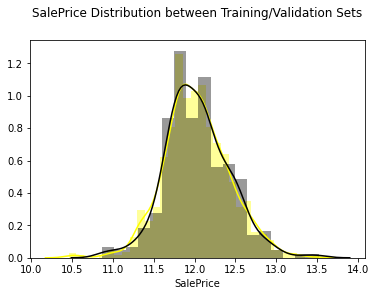

In [28]:
sns.distplot(y_train_l,kde=True,color='yellow')
sns.distplot(y_val_l,kde=True,color='black')
plt.title('SalePrice Distribution between Training/Validation Sets',y=1.08)

# 3. Building a Random Forest Model:
Some important parameters of the RandomForestRegessor() from Scikit-Learn include:
* **n_estimators**: The number of trees in the forest.
* **min_samples_leaf**: The minimum number of samples that a leaf node must contain.
* **max_features**: the portion of features that are available to the algorithm at each decision point. Limiting the number of features available at a decision point makes individual trees less accurate, but makes all trees in the random forest less correlated to each other, which is useful in preventing overfitting.
* **oob_score**: takes samples that were not included in the training of the decision trees, and calculates the R^2 on these "out-of-bag" samples. The OoB score is a good substitute for a validation set when you don't have enough data to set aside for validation. OoB Score is normally lower than validation score.

We now write a functio to build a random forest model and print the out-of-bag score (R^2). Note that R^2 is not the evaluation metric of the competition, but having the OoB score print out can help us diagnose model performance.

In [29]:
def train_rf_regressor(n_trees, min_samples_leaf, X_train, y_train, X_val, y_val, error_type, max_features = 'auto'):
    """Fit a random forest regressor given a training set, get the out-of-bag score (R^2), 
    and calculate the error on the validation set given an error type (MSE or MAE)."""
    forest = RandomForestRegressor(n_estimators = n_trees, min_samples_leaf = min_samples_leaf,\
                              max_features = max_features, oob_score = True, random_state = 42)
    forest.fit(X_train, y_train)
    preds = forest.predict(X_val)
    
    if error_type == 'rmse': 
        error = mean_squared_error(y_val, preds, squared = False)
    elif error_type == 'mae':
        error = mean_absolute_error(y_val, preds)
    
    print('OoB Score: {}, Validation Error ({}): {}'.format(forest.oob_score_,error_type,error))
    return forest,preds,error

#calculate RMSE using the one hot and label encoded datasets
forest_o,preds_o,error_o = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train_o,\
                                        y_train=y_train_o, X_val=X_val_o, y_val=y_val_o, error_type='rmse')

forest_l,preds_l,error_l = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train_l,\
                                        y_train=y_train_l, X_val=X_val_l, y_val=y_val_l, error_type='rmse')

OoB Score: 0.8676527918009209, Validation Error (rmse): 0.1504094325071998
OoB Score: 0.8665873466483889, Validation Error (rmse): 0.15226823577444754


We see that the label encoded dataset is not initially performing better than the one hot encoded dataset, but we will continue to develop our model using the label encoded dataset.

We can visualize the first tree in the forest to see what kinds of decisions it is making.

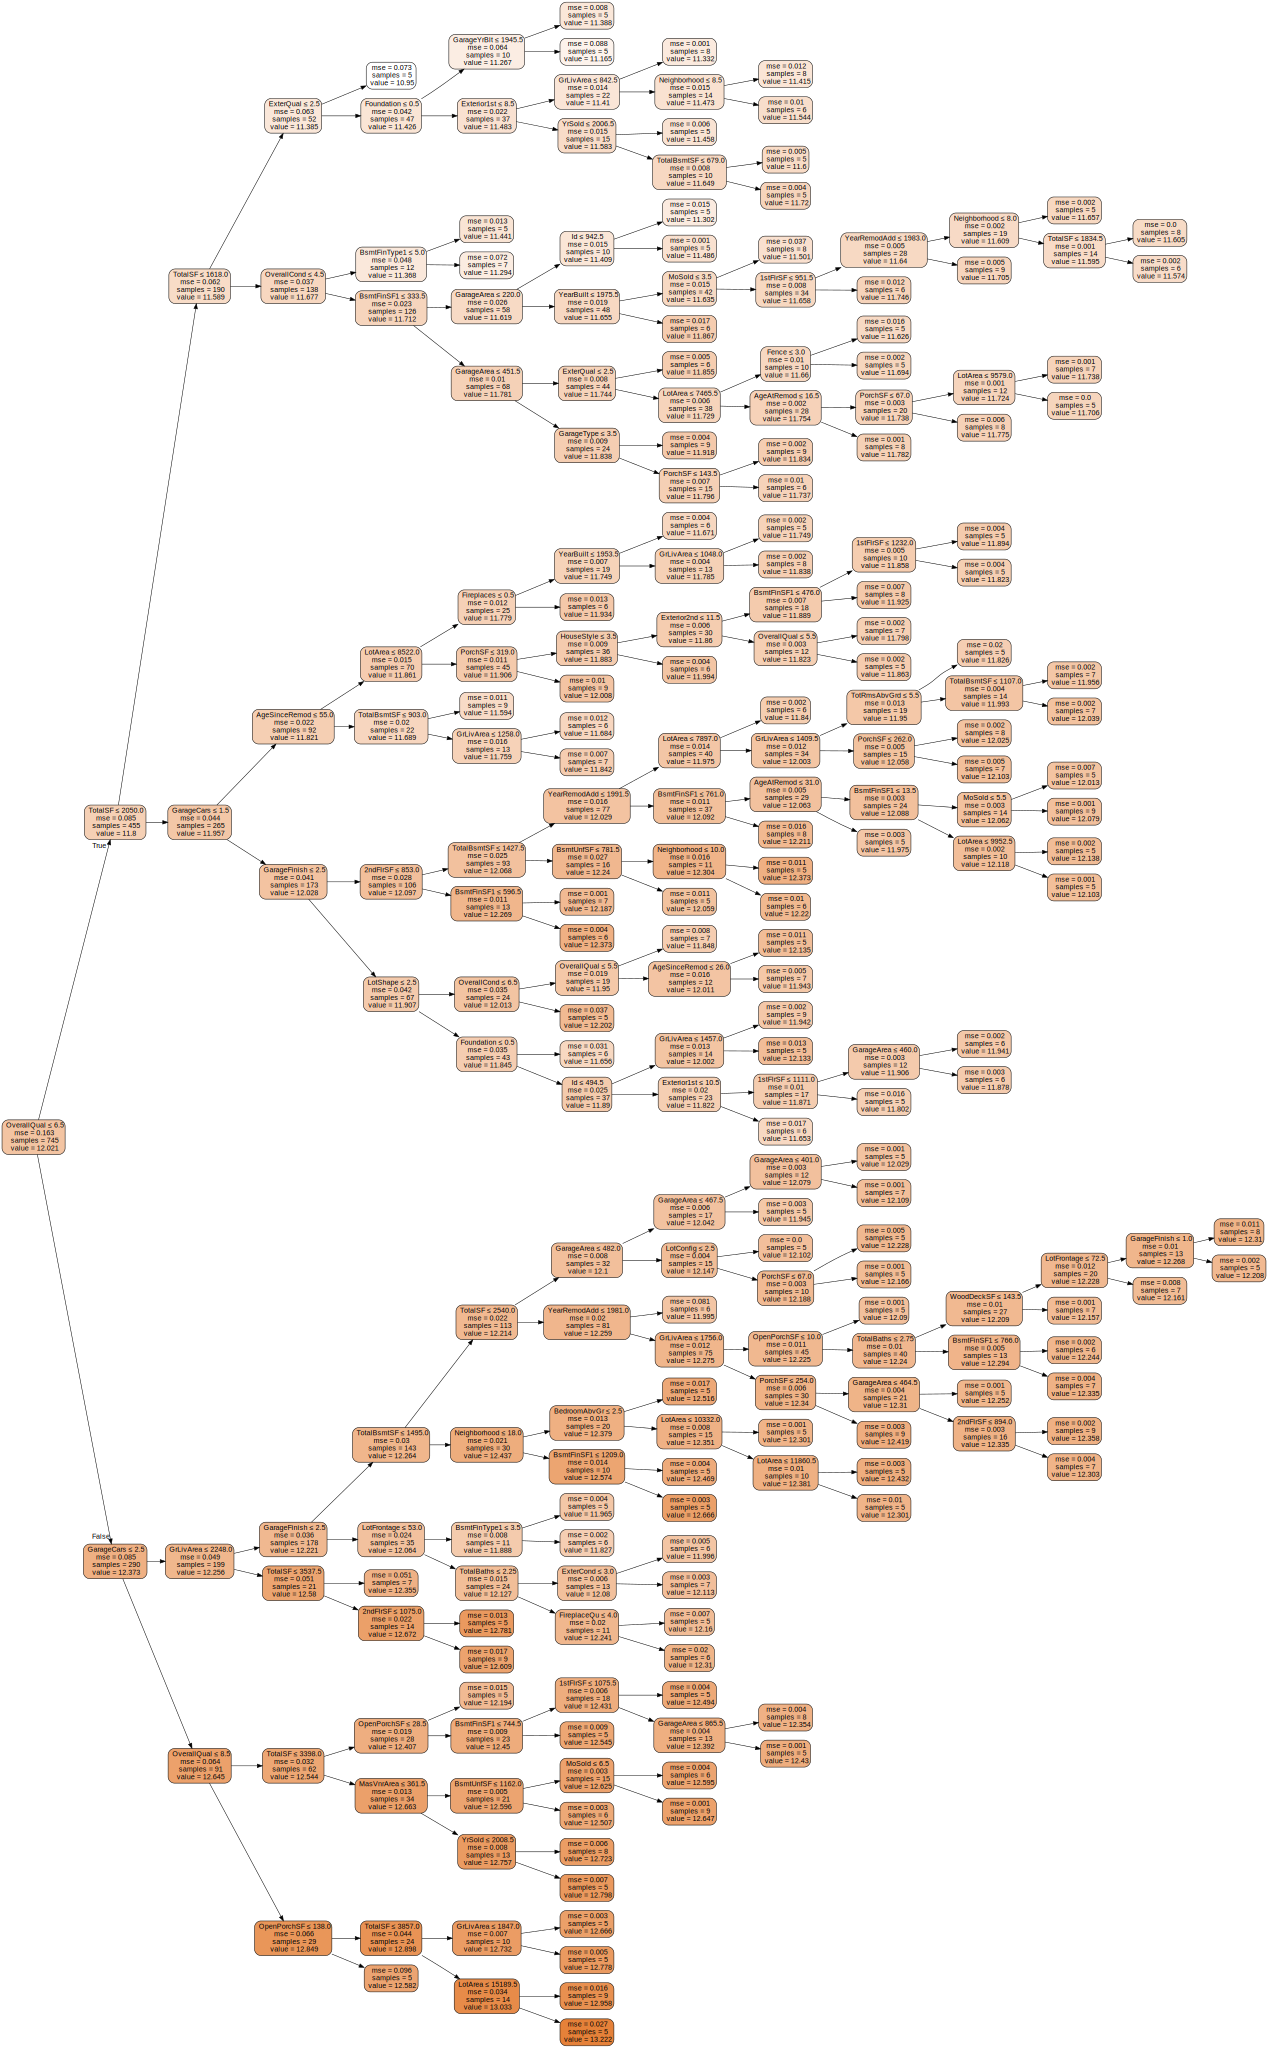

In [30]:
#visualize first tree in random forest model
%matplotlib inline
dot_data = tree.export_graphviz(forest_l.estimators_[0], out_file=None, feature_names=X_train_l.columns,\
                                rounded=True,filled=True, special_characters=True, rotate=True) 
draw = graphviz.Source(dot_data)
draw

## 3.1 Evaluating Model Predictions Using Standard Deviation:
Random forests make predictions by averaging the predictions from each tree for a given sample in the validation set. Knowing this, it is possible to calculate the standard deviation of predictions across all trees in the forest for every sample in the validation set. Dividing the standard deviation of predictions by the mean prediction for each sample, we can gauge the "confidence" of the random forest in the predictions it makes for each sample. A higher standard deviation relative the mean indicates more variance in predictions, therefore, the forest is less confident.

In [31]:
def pred_confidence(forest, X_val, y_val):
    """Create new dataframe with the prediction mean and standard deviation for all predictions on a sample
    across all the trees in a random forest."""
    #stack predictions from random forest to a single axis
    predictions = np.stack([tree.predict(X_val) for tree in forest.estimators_])
    
    X_val_w_std = X_val.copy()
    
    #add target variable
    X_val_w_std['Actual'] = y_val
    
    #average the predictions from each tree for each validation set sample
    X_val_w_std['Mean Prediction'] = np.mean(predictions,axis=0)
    
    #calculate standard deviation of predictions from each tree for each validation set sample
    X_val_w_std['Standard Deviation'] = np.std(predictions,axis=0)
    
    #standard deviation / mean for each sample indicates the confidence the forest has in the predicted value for each sample
    X_val_w_std['STD/Mean'] = X_val_w_std['Standard Deviation'] / X_val_w_std['Mean Prediction']
    
    #sort by std/mean from low-to-high for display
    X_val_w_std[['Mean Prediction','Standard Deviation','STD/Mean']].sort_values('STD/Mean')
    
    return X_val_w_std

confidences = pred_confidence(forest=forest_l,X_val=X_val_l,y_val=y_val_l)

In [32]:
#calculate range of STD/Mean for all predictions in the validation set
least_confident = confidences['STD/Mean'].min()
most_confident = confidences['STD/Mean'].max()
print(f'Prediction STD/Mean ("prediction confidence") ranges from {round(least_confident,6)} - {round(most_confident,6)}')

Prediction STD/Mean ("prediction confidence") ranges from 0.003086 - 0.024653


Text(0.5, 1.0, 'Variance of Prediction Confidence in Random Forest')

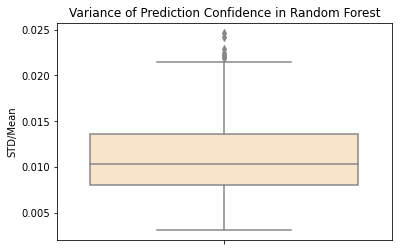

In [33]:
#create boxplot to visualize prediction confidence
sns.boxplot('STD/Mean', data = confidences, orient = 'v', color = 'bisque')
plt.title('Variance of Prediction Confidence in Random Forest')

We can describe the features for the 50 predictions the random forest was most confident in. This information could prove useful in later stages of model tuning / feature engineering.

In [34]:
confidences.sort_values('STD/Mean').head(50).describe()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,TotalBaths,PorchSF,AgeAtRemod,AgeSinceRemod,Pool,2ndFlr,Garage,FirePlace,Bsmt,Actual,Mean Prediction,Standard Deviation,STD/Mean
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,50.000000,50.000000,50.0,50.000000,50.0,50.000000,50.000000,50.0,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.0,50.000000,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,50.000000,50.000000,50.0,50.000000,50.00000,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.0,50.0,50.000000,50.000000,50.000000,50.0,50.000000,50.0,50.0,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,50.0,50.000000,50.0,50.000000,50.000000,50.000000,50.000000
mean,1301.720000,56.600000,2.900000,68.495043,8727.320000,1.0,1.040000,1.880000,2.960000,0.0,3.440000,0.0,11.560000,2.080000,2.0,0.62000,3.520000,6.440000,5.240000,1992.240000,1994.120000,1.28000,1.0,10.200000,10.940000,1.720000,84.524026,2.440000,3.960000,1.720000,2.44000,3.820000,3.060000,2.900000,512.400000,5.880000,16.240000,499.34000,1027.980000,1.0,0.760000,1.0,3.920000,1049.500000,355.780000,1.600000,1406.880000,0.640000,0.0,1.640000,0.480000,2.720000,1.0,2.300000,6.16000,6.0,0.420000,3.220000,1.520000,1992.920000,1.740000,1.980000,515.180000,5.0,5.0,2.0,78.360000,68.060000,7.000000,0.0,7.360000,0.0,3.0,3.56000,1.080000,40.000000,6.840000,2007.880000,7.800000,3.94000,2433.26000,2.520000,160.780000,1.880000,13.760000,0.0,0.420000,1.0,0.420000,1.0,12.089769,12.090984,0.069967,0.005786
std,82.278779,39.037397,0.707107,15.392877,2639.895007,0.0,0.197949,1.451811,0.282843,0.0,1.264266,0.0,6.111748,0.778276,0.0,1.44123,1.631826,0.951047,0.686904,16.016012,14.892321,0.70102,0.0,2.602981,2.992576,0.536048,127.094658,0.501427,0.282843,0.453557,0.92934,0.719694,1.695251,2.178279,377.280981,0.593846,80.626769,423.54397,262.898016,0.0,1.450686,0.0,0.565685,268.503582,434.379092,11.313708,388.482061,0.484873,0.0,0.484873,0.504672,0.640153,0.0,0.580288,1.34559,0.0,0.498569,1.130107,1.328495,15.573185,1.065412,0.514682,160.041282,0.0,0.0,0.0,100.117229,71.220958,34.810859,0.0,42.048446,0.0,0.0,1.01338,0.395897,213.808994,2.923236,1.319245,0.606092,0.86685,499.88255,0.646498,110.250418,8.087885,14.863405,0.0,0.498569,0.0,0.498569,0.0,0.223991,0.233179,0.012747,0.001047
min,1172.000000,20.000000,1.000000,30.000000,2117.000000,1.0,1.000000,0.000000,1.000000,0.0,0.000000,0.0,5.000000,0.000000,2.0,0.00000,2.000000,5.000000,5.000000,1956.000000,1956.000000,1.00000,1.0,5.000000,5.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,14.00000,600.000000,1.0,0.000000,1.0,0.000000,520.000000,0.000000,0.000000,848.000000,0.000000,0.0,1.000000,0.000000,1.000000,1.0,0.000000,3.00000,6.0,0.000000,0.000000,1.000000,1956.000000,0.000000,1.000000,264.000000,5.0,5.0,2.0,0.000000,0.000000,0.000000,0.0,0.

In [35]:
def feature_confidence(df,feature):
    """For a dataframe of validation set predictions where the prediction means, STD, and STD/mean have already been calculated, 
    we can group the dataframe by a given feature to see how much STD we have in the predictions."""
    
    fields = [feature,'Mean Prediction','Standard Deviation','STD/Mean']
    
    #group dataframe by feature, and sort by STD/Mean 
    feature_conf = df[fields].groupby(feature,as_index=False,axis=0).mean().sort_values('STD/Mean').reset_index(drop=True)
    
    #count the number of observations for each category in a given feature
    counts = collections.Counter(df[feature])
    
    #create new column to display number of observations for each category in a feature
    feature_conf['Observations'] = feature_conf[feature].replace(counts)
    return feature_conf

We can also inspect each feature, and evaluate which categories/values of that feature most often had predictions that the random forest was confident in. I have included the number of observations for each feature as well, because categories with a low number of observations will naturally have lower standard deviations relative to the mean.

For example, the model is quite confident in predictions where Neighborhood = 13 (below), but there are only 2 observations with this neighborhood, so the prediction confidence is less significant. But when we look at predictions for Neighborhood = 5, we see that the model is quite confident in its predictions, even with a fairly large number of observations. Therefore, Neighborhood = 5 could be a useful feature to add to the dataset as its own column.

In [36]:
feature_confidence(confidences, 'Neighborhood').head(10)

,Neighborhood,Mean Prediction,Standard Deviation,STD/Mean,Observations
0,5,12.181367,0.089993,0.007379,32
1,22,12.441086,0.103934,0.008354,2
2,21,12.271700,0.103264,0.008393,20
3,16,12.525484,0.107337,0.008542,9
4,8,12.163018,0.106739,0.008767,15
5,24,12.380655,0.113369,0.009157,1
6,11,11.883467,0.109922,0.009244,12
7,13,11.816463,0.114549,0.009694,2
8,0,12.286047,0.120168,0.009781,2
9,12,11.868711,0.122216,0.010284,47


## 3.2 Feature Importance:
For a random forest, feature importance is calculated using the following steps:
* 1. Train a random forest with all features, calculate R^2 score.
* 2. Take a given feature (ex. 'OverallQual') and randomly shuffle it, without affecting other features. The distribution of the feature hasn't changed, but it is now no longer related to dependent (target) variable). 
* 3. Recalculate R^2 score using shuffled feature.
* 4. Record amount of decrease in R^2 score before and after shuffling feature.
* 5. Repeat for all features.

More important features lead to larger decreases in R^2 when randomly shuffled. The RandomForestRegressor() has calculated feature importance for us, we must simply retrieve and display this information.

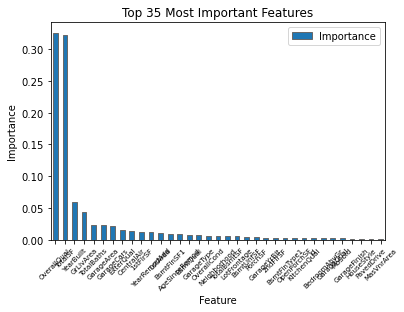

,Feature,Importance
0,OverallQual,0.325794
1,TotalSF,0.321338
2,YearBuilt,0.058552
3,GrLivArea,0.043758
4,TotalBaths,0.022610
5,GarageArea,0.022495
6,GarageCars,0.021838
7,ExterQual,0.014663
8,CentralAir,0.013308
9,1stFlrSF,0.012682


In [37]:
def feature_importance(forest, n_features, X_val):
    """For a random forest, display the n most important features as a dataframe, and generate a bar chart
    to visualize feature importance"""
    
    #get feature importances from sklearn
    feat_imp = forest.feature_importances_

    #get index of top n features sorted from greatest to least importance
    importance_index = list(np.argsort(-feat_imp))[0:n_features]
    
    #get the names of the most important features from the validation set columns
    important_feature_names = list(X_val.columns[importance_index])
    
    #create dataframe of most important features, and show their importance
    best_features = pd.DataFrame({'Feature': important_feature_names,'Importance': feat_imp[importance_index]})
    
    ax = best_features.plot(kind = 'bar', edgecolor='dimgrey')
    ax.set_xticks(best_features.index)
    ax.set_xticklabels(best_features.Feature,rotation=45,fontsize=7)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top {} Most Important Features'.format(n_features))
    plt.show()
    return best_features

best_features_l=feature_importance(forest=forest_l,n_features=35,X_val=X_val_l)
best_features_l.head(10)

In [38]:
best_features_l

,Feature,Importance
0,OverallQual,0.325794
1,TotalSF,0.321338
2,YearBuilt,0.058552
3,GrLivArea,0.043758
4,TotalBaths,0.022610
5,GarageArea,0.022495
6,GarageCars,0.021838
7,ExterQual,0.014663
8,CentralAir,0.013308
9,1stFlrSF,0.012682


We see that there are 2 features that stand out as being extremely important: *OverallQual* and *TotalSF*. *TotalSF* was one of the features we quickly created earlier in the process. Although it is tempting to throw away a lot of the variables that seem unimportant in comparison the *OverallQual* and *TotalSF*, we cannot ignore them all. 

We must decide which variables to keep, and which to throw away. After some manual tinkering, I decided to keep features with more than 0.001 importance. This may seem small, but only next to the 2 most important features.

In [39]:
#keep variables with importance > 0.001
to_keep = list(best_features_l[best_features_l.Importance >= 0.001].Feature) + ['SalePrice']
print('Number of features to keep: ', len(to_keep))

Number of features to keep:  36


In [40]:
to_keep

['OverallQual',
 'TotalSF',
 'YearBuilt',
 'GrLivArea',
 'TotalBaths',
 'GarageArea',
 'GarageCars',
 'ExterQual',
 'CentralAir',
 '1stFlrSF',
 'YearRemodAdd',
 'LotArea',
 'BsmtFinSF1',
 'AgeSinceRemod',
 'BsmtQual',
 'GarageType',
 'OverallCond',
 'Neighborhood',
 'TotalBsmtSF',
 'LotFrontage',
 'BsmtUnfSF',
 'PorchSF',
 'GarageYrBlt',
 '2ndFlrSF',
 'BsmtFinType1',
 'OpenPorchSF',
 'KitchenQual',
 'Id',
 'BedroomAbvGr',
 'GarageQual',
 'MoSold',
 'GarageFinish',
 'HouseStyle',
 'PavedDrive',
 'MasVnrArea',
 'SalePrice']

We use previously written functions to generate new training / validation / test sets using just the features we decided to keep, and then train a random forest on the modified dataset.

In [41]:
df_keep = df_label[to_keep]

X_train2, y_train2, X_val2, y_val2, X_test2 = make_train_val_test_sets(df=df_keep, val_size_pct=0.2, target_name='SalePrice')

df_keep.shape,X_train2.shape,X_val2.shape

((2919, 36), (1168, 35), (292, 35))

In [42]:
forest,preds,error = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train_l,\
                                        y_train=y_train_l, X_val=X_val_l, y_val=y_val_l, error_type='rmse')

forest2,preds2,error2 = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train2,\
                                        y_train=y_train2, X_val=X_val2, y_val=y_val2, error_type='rmse')

OoB Score: 0.8665873466483889, Validation Error (rmse): 0.15226823577444754
OoB Score: 0.8676688544139195, Validation Error (rmse): 0.14999701321076664


Our model performance has improved **~2%**, and we have reduced the number of features from 90 to 36! This is an encouragin signal that we are moving in the right direction, and starting to hone in on what features drive housing prices.

## 3.3 Identifying Redundant Features:
We can attempt to further reduce our feature set by identifying redundant features. To do this, we will:
* 1. Calculate Spearman rank correlation of features.
* 2. Cluster features according to their Spearman rank correlation.

### 3.3.1 Spearman Rank Correlation:
The **Spearman rank correlation** evaluates the monotonic relationship between two variables. A Spearman rank correlation of +1 means that as the value of one variable increases, so does the value of the other. Spearman rank correlation is often used to evaluate relationships between ordinal variables. Spearman correlations also do not necessarily indicate a linear relationship, only that the variables tend to change together. [A comparison of the Pearson and Spearman correlation methods](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.)

### 3.3.2 Agglomerative Clustering:
Once the Spearman correlations have been calculated for the features, the features are clustered by their Spearman rank correlation using **agglomerative** (or **hierarchical clustering**), where features are grouped in pairs successively until all pairs have been merged into one cluster containing all features. Features are grouped into clusters/pairs based on their "distance" from each other. This can be visualized using a **dendrogram**. 

In [43]:
def spearman_dendrogram(df):
    """Plot a dendrogram of the Spearman rank correlations of the features in a training/validation set."""
    
    #n x n matrix of spearman rank correlations
    correlation = np.round(scipy.stats.spearmanr(df).correlation, 4)
    
    #produce condensed matrix of correlation coefficients
    corr_condensed = hc.distance.squareform(1-correlation)
    
    #perform agglomerative clustering (returns (n-1) x 4 column matrix) where n-1 is the number of clustering iterations
    #first 2 columns represent 'clusters' that are being compared in the ith iteration
    #3rd column represents computed distance between clusters
    #4th column represents number of original observations in the new cluster
    z = hc.linkage(corr_condensed, method='average')
    
    #plot dendrogram to visualize agglomerative clustering
    fig = plt.figure(figsize=(15,10))
    dendrogram = hc.dendrogram(z, labels=list(df.columns), orientation='left')
    plt.show()
    return correlation, corr_condensed, z

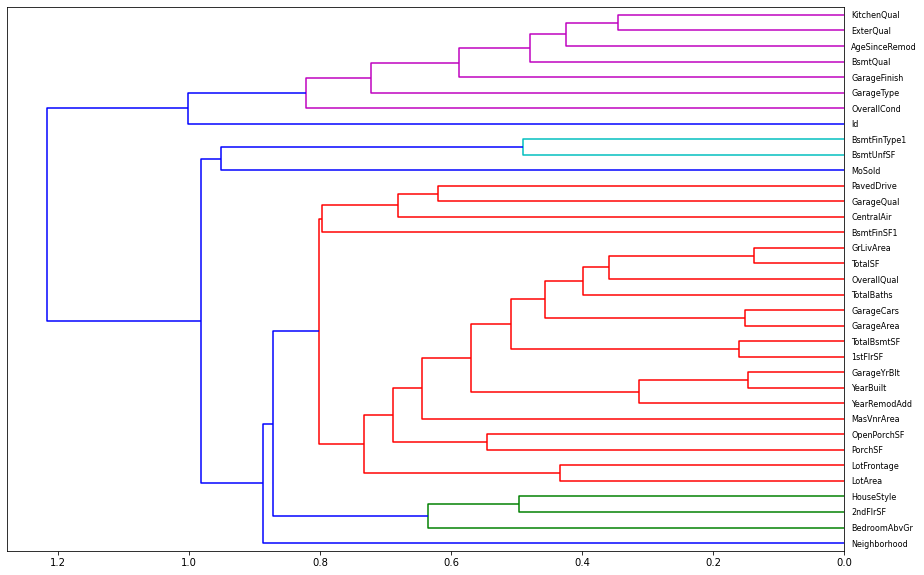

In [44]:
correlation, corr_condensed, z = spearman_dendrogram(df=X_train2)

In [45]:
correlation.shape, corr_condensed.shape, z.shape

((35, 35), (595,), (34, 4))

The dendrogram x-axis represents the calculated distance between features (in this case the distance is based on their Spearman correlation). Based on the Spearman rank correlation, the dendrogram clusters features together by their similarity (or distance). Clusters/pairs that merge at a lower value on the x-axis are more strongly correlated (ie. their distance from each is other in Euclidean space is smaller).

From the dendrogram, we can see that there are 4 pairs where to two features appear very correlated. They are: *GrLivArea & TotalSF, GarageCars & GarageArea, TotalBsmtSF & 1stFlrSF, and GarageYrBlt & YearBuilt*. 

We can tabulate the dendrogram and quantify the distance between these features as seen below. In the dataframe below, we can see that some features do not have names. This is because not all features in the dataframe are original features from the training set. For example, in row 4, we see *YearRemodAdd* has been paired with Feature #36. From the dendrogram, we can see that *YearRemodAdd* has been paired with a cluster that is itself a cluster of *GarageYrBlt* & *YearBuilt*, therefore it does not have a name that can be traced back to the original dataset.

In [46]:
def linkage_df(z, feature_names):
    """Convert linkage array generated by SciPy to a Pandas Dataframe, sorted by distance of clusters.
        Map feature indices back to their original feature names.
        NOTE: Features that don't end up with a name after mapping are because they have been clustered together.""" 
    
    #create dictionary mapping feature number from the Spearman correlations to a feature name
    feature_name_map = dict(enumerate(list(feature_names)))
    
    #create dataframe of SciPy clustering linkages
    z = pd.DataFrame(z,columns=['Feature1','Feature2','Distance','Observations'])
    
    #replace feature numbers with feature names using feature_name_map
    z.Feature1 = z.Feature1.replace(feature_name_map)
    z.Feature2 = z.Feature2.replace(feature_name_map)
    
    #sort dataframe by "distance" or correlation between features
    z = z.sort_values('Distance')
    return z

z = linkage_df(z, X_train2.columns)
z.head(20)

,Feature1,Feature2,Distance,Observations
0,TotalSF,GrLivArea,0.138200,2.0
1,YearBuilt,GarageYrBlt,0.147200,2.0
2,GarageArea,GarageCars,0.151600,2.0
3,1stFlrSF,TotalBsmtSF,0.160600,2.0
4,YearRemodAdd,36,0.312600,3.0
5,ExterQual,KitchenQual,0.345300,2.0
6,OverallQual,35,0.359650,3.0
7,TotalBaths,41,0.398300,4.0
8,AgeSinceRemod,40,0.425100,3.0
9,LotArea,LotFrontage,0.433500,2.0


The first 4 rows of the dataframe are the most closely correlated feature pairs. We can set them aside and experiment with removing them one at a time from the model and evaluate what impact that has on the model's performance.

In [47]:
#take the first 5 most closely clustered features
closest_cluster_pairs = z[['Feature1','Feature2']].head(4)

#generate a list of those features
potential_redundant_feats = [feat for feat in closest_cluster_pairs.Feature1] +\
            [feat for feat in closest_cluster_pairs.Feature2]

In [48]:
potential_redundant_feats

['TotalSF',
 'YearBuilt',
 'GarageArea',
 '1stFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageCars',
 'TotalBsmtSF']

In [49]:
#empty variable that will be updated if model improves by dropping a given feature
rf_improves_without=[]

#drop selected features one at a time and re-train random forest without the feature, and determine if the MAE is lower
#without the dropped feature.
for f in tuple(potential_redundant_feats):
    X_train_dropped_f = X_train2.copy().drop(f,axis=1)
    X_val_dropped_f = X_val2.copy().drop(f,axis=1)
    print(f,': ')
    forest_f,preds_f,error_f = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train_dropped_f,\
                                        y_train=y_train2, X_val=X_val_dropped_f, y_val=y_val2, error_type='rmse')
    
    #if RMSE of random forest is lower without the feature, add that feature to the 'to_drop' list
    if error_f < error2: 
        print('Dropping {} reduced RMSE by {}'.format(f, round(error - error_f, 6)))
        rf_improves_without.append(f)
    else:
        print(f'Dropping {f} did not reduce RMSE')
        
rf_improves_without;

TotalSF : 
OoB Score: 0.8610073310634315, Validation Error (rmse): 0.1528147129336607
Dropping TotalSF did not reduce RMSE
YearBuilt : 
OoB Score: 0.8656549700617056, Validation Error (rmse): 0.15428109779400198
Dropping YearBuilt did not reduce RMSE
GarageArea : 
OoB Score: 0.8694156909068329, Validation Error (rmse): 0.1535403337640038
Dropping GarageArea did not reduce RMSE
1stFlrSF : 
OoB Score: 0.8700140288065148, Validation Error (rmse): 0.15409698889654724
Dropping 1stFlrSF did not reduce RMSE
GrLivArea : 
OoB Score: 0.8674180642566103, Validation Error (rmse): 0.1512972025246802
Dropping GrLivArea did not reduce RMSE
GarageYrBlt : 
OoB Score: 0.8675981001660187, Validation Error (rmse): 0.15004769750945804
Dropping GarageYrBlt did not reduce RMSE
GarageCars : 
OoB Score: 0.8666988784593597, Validation Error (rmse): 0.15551321326158749
Dropping GarageCars did not reduce RMSE
TotalBsmtSF : 
OoB Score: 0.8700189267235955, Validation Error (rmse): 0.15064562941365628
Dropping Total

We can see that dropping *GrLivArea*, *GarageYrBlt*, and *TotalBsmtSF* individually had a positive impact on the RMSE, which indicates that they were redundant features that can be removed from the model. 

Additionally, after more manual experimentation, I have selected a handful of other features to remove from the feature set based on their feature importance (as calculated in Section 3.2), and their correlation to other features as seen in the dendrogram. 

We take this list of variables that have been identified as removable, and re-train the model with the reduced feature set.

In [50]:
to_drop = ['GrLivArea','GarageYrBlt','BsmtUnfSF','AgeSinceRemod','PavedDrive','GarageFinish','2ndFlrSF','1stFlrSF']

In [51]:
df_keep2 = df_keep.drop(to_drop,axis=1)

X_train3, y_train3, X_val3, y_val3, X_test3 = make_train_val_test_sets(df=df_keep2, val_size_pct=0.2, target_name='SalePrice')

forest,preds,error = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train_l,\
                                        y_train=y_train_l, X_val=X_val_l, y_val=y_val_l, error_type='rmse')

forest2,preds2,error2 = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train2,\
                                        y_train=y_train2, X_val=X_val2, y_val=y_val2, error_type='rmse')

forest3,preds3,error3 = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train3,\
                                        y_train=y_train3, X_val=X_val3, y_val=y_val3, error_type='rmse')

OoB Score: 0.8665873466483889, Validation Error (rmse): 0.15226823577444754
OoB Score: 0.8676688544139195, Validation Error (rmse): 0.14999701321076664
OoB Score: 0.870441528108396, Validation Error (rmse): 0.14609728661191174


In [52]:
print(f'Feature set is now {len(X_train3.columns)} features')

Feature set is now 27 features


In [53]:
df_keep2.columns

Index(['OverallQual', 'TotalSF', 'YearBuilt', 'TotalBaths', 'GarageArea',
       'GarageCars', 'ExterQual', 'CentralAir', 'YearRemodAdd', 'LotArea',
       'BsmtFinSF1', 'BsmtQual', 'GarageType', 'OverallCond', 'Neighborhood',
       'TotalBsmtSF', 'LotFrontage', 'PorchSF', 'BsmtFinType1', 'OpenPorchSF',
       'KitchenQual', 'Id', 'BedroomAbvGr', 'GarageQual', 'MoSold',
       'HouseStyle', 'MasVnrArea', 'SalePrice'],
      dtype='object')

## 3.4 Univariate Data Visualization:
Now that our feature set is fairly small, we can do some univariate analysis to identify ways we can further improve model performance. Below are histograms and boxplots of the distribution of all features remaining in the feature set to visualize the statistical distribution of the features.

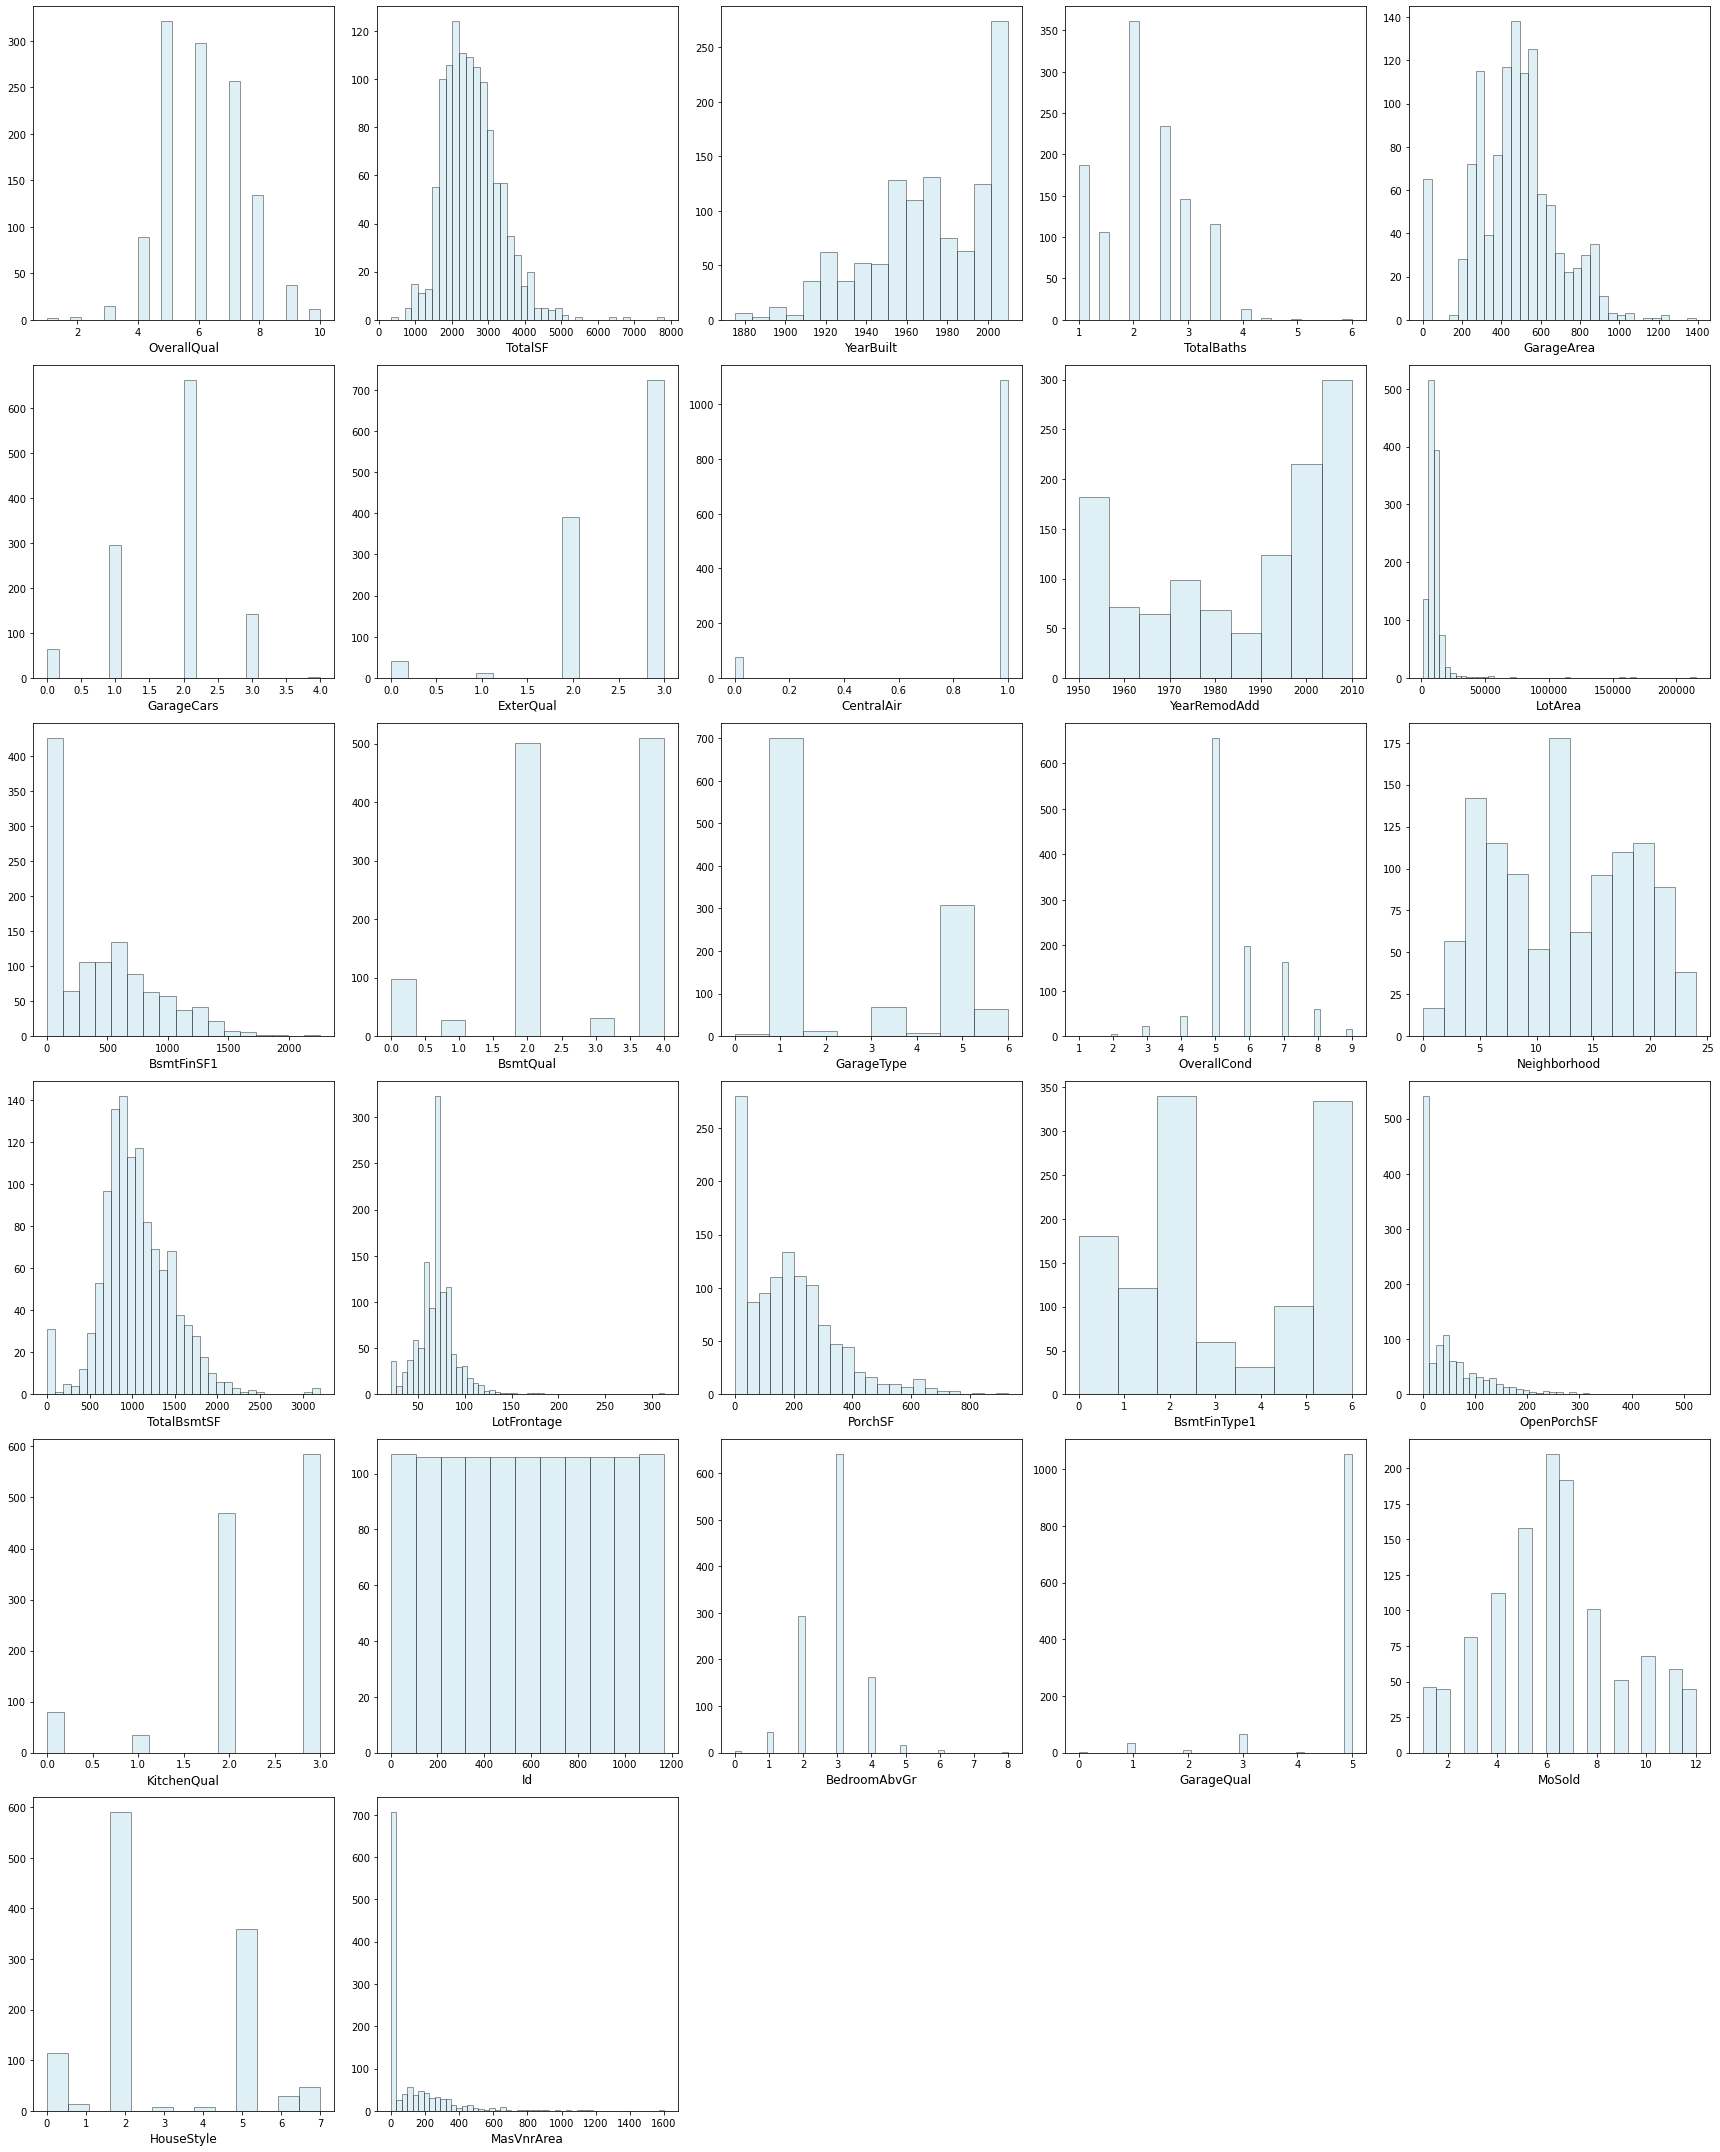

In [54]:
def feature_distributions(df):
    """Plot histograms of all features in a given dataset"""
    
    dimension = math.ceil(math.sqrt(len(df.columns)))
    plt.figure(figsize = [dimension * 4, dimension* 5])
    
    for i in range(0,len(df.columns)):
        plt.subplot(len(df.columns)/4, 5, i+1)
        sns.distplot(df[df.columns[i]], kde = False, color='lightblue',hist_kws=dict(edgecolor="k", linewidth=1))
        plt.xlabel(f'{df.columns[i]}',fontsize=dimension * 2)
        plt.tight_layout()
    return

feature_distributions(X_train3)

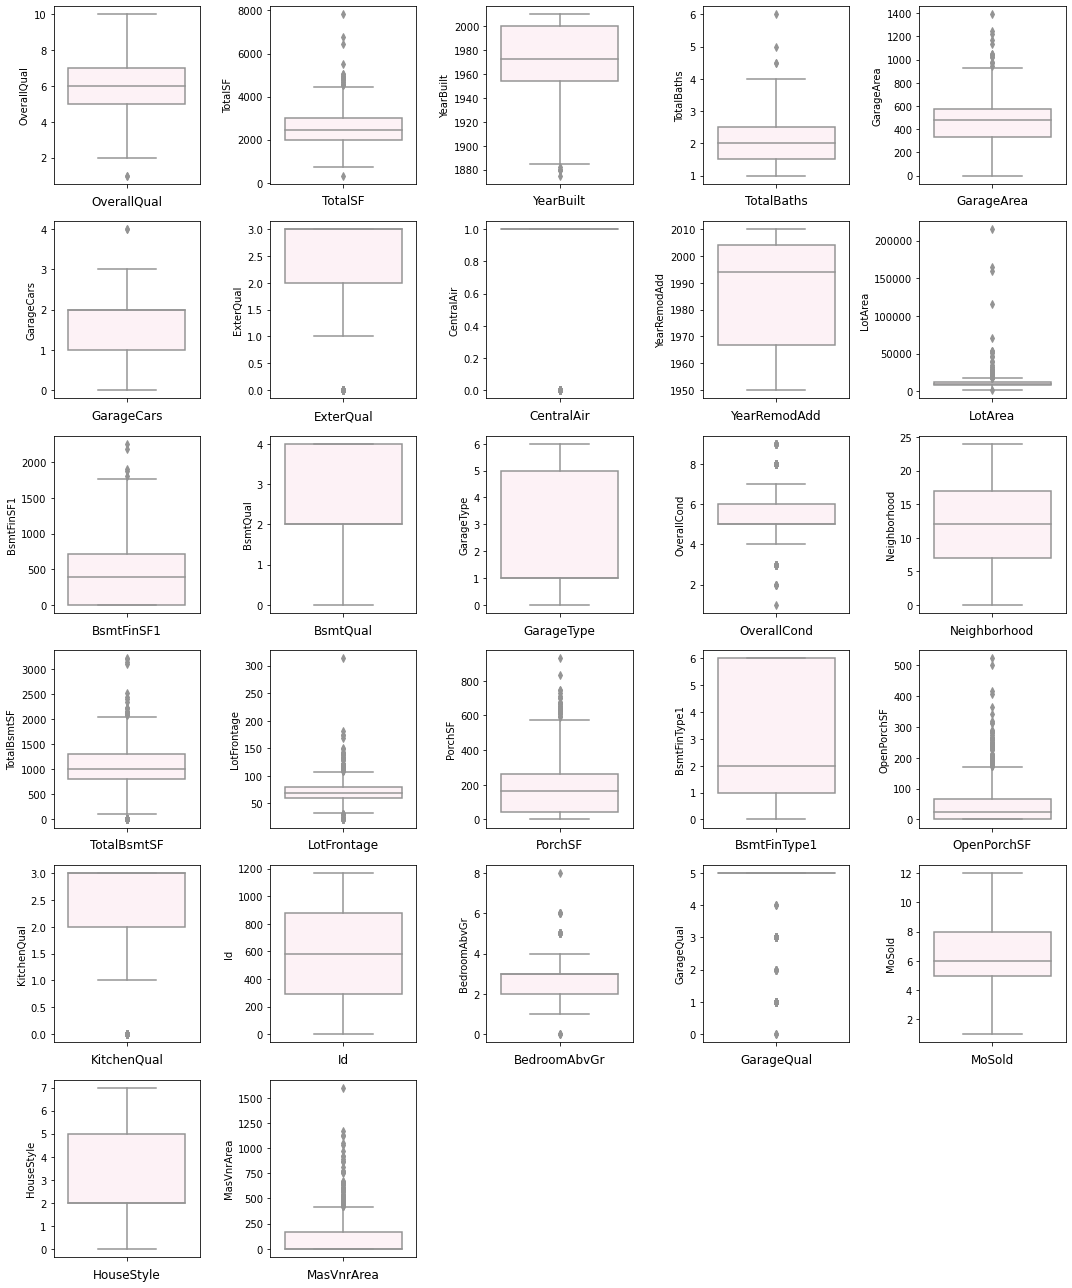

In [55]:
def feature_boxplots(df):
    """Plot box plots of all features in a given dataset"""
    
    dimension = math.ceil(math.sqrt(len(df.columns)))
    plt.figure(figsize = [dimension * 2.5, dimension * 3])
    
    for i in range(0,len(df.columns)):
        plt.subplot(len(df.columns)/4, 5, i+1)
        sns.boxplot(df[df.columns[i]], orient='v', color = 'lavenderblush')
        plt.xlabel(f'{df.columns[i]}',fontsize=dimension * 2)
        plt.tight_layout()
    return

feature_boxplots(X_train3)

## 3.6 Outlier Handling:
From the visualizations in Section 3.5, we can see there are some features with extreme outliers that may be distorting relationships between features. For example, the *TotalSF* feature appears to have a few outliers beyond 6000 sq. ft. Similarily, the *OverallQual* feature has a very small number of extremely low quality homes (quality score < 2). We can drop these rows from our training/validation set.

In [56]:
training_index_to_drop = list(X_train3[X_train3['TotalSF'] > 6000].index) \
    + list(X_train3[X_train3['OverallQual'] < 2].index) + list(X_train3[X_train3['PorchSF'] > 700].index) \
    + list(X_train3[X_train3['TotalBaths'] > 5].index)
val_index_to_drop = list(X_val3[X_val3['TotalSF'] > 6000].index) \
    + list(X_val3[X_val3['OverallQual'] < 2].index) + list(X_val3[X_val3['PorchSF'] > 700].index) \
    + list(X_val3[X_val3['TotalBaths'] > 5].index)
training_index_to_drop, val_index_to_drop

([496, 523, 691, 375, 533, 53, 769, 800, 828, 848, 854, 961, 1068, 738],
 [1182, 1298, 1210, 1328, 1423, 1459])

In [57]:
#remove outliers from training set
X_train4 = X_train3.drop(training_index_to_drop)

#remove corresponding sale prices from training set
y_train4 = y_train3.drop(training_index_to_drop)

#remove outliers from training set
X_val4 = X_val3.drop(val_index_to_drop)

#remove corresponding sale prices from training set
y_val4 = y_val3.drop(val_index_to_drop)

In [58]:
X_train4.shape, X_train3.shape

((1154, 27), (1168, 27))

In [59]:
y_train4.shape, y_train3.shape

((1154,), (1168,))

In [60]:
X_val4.shape, X_val3.shape

((286, 27), (292, 27))

In [61]:
y_val4.shape, y_val3.shape

((286,), (292,))

In [62]:
#ensure the test set has not changed (must have 1459 rows)
X_test3.shape

(1459, 27)

In [63]:
forest,preds,error = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train_l,\
                                        y_train=y_train_l, X_val=X_val_l, y_val=y_val_l, error_type='rmse')

forest2,preds2,error2 = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train2,\
                                        y_train=y_train2, X_val=X_val2, y_val=y_val2, error_type='rmse')

forest3,preds3,error3 = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train3,\
                                        y_train=y_train3, X_val=X_val3, y_val=y_val3, error_type='rmse')

forest4,preds4,error4 = train_rf_regressor(n_trees=40, min_samples_leaf=5, max_features = 0.5, X_train=X_train4,\
                                        y_train=y_train4, X_val=X_val4, y_val=y_val4, error_type='rmse')

OoB Score: 0.8665873466483889, Validation Error (rmse): 0.15226823577444754
OoB Score: 0.8676688544139195, Validation Error (rmse): 0.14999701321076664
OoB Score: 0.870441528108396, Validation Error (rmse): 0.14609728661191174
OoB Score: 0.8634479459887221, Validation Error (rmse): 0.1320210280800648


Putting it all together, we can see that our model has improved **~15%** from where it began.

## 3.7 Partial Dependence & Interaction Plots:
**Partial dependence plots** (PDPs) help to visualize the change in sale price as a result of altering a particular feature. PDPs answer the question, "How much would this house have sold for if we changed INSERT_FEATURE_NAME, all else being equal?"

**Interaction plots** can help visualize how the targe variable (sale price) varies as a result of the interaction of two different features.

These plots can be great tools to visualize the impact that features have on the target variable. Some examples are shown below.

In [64]:
def plot_pdp(feat, forest, data, clusters=None):
    """Generate partial dependence plot for a given feature in a random forest"""
    p = pdp.pdp_isolate(forest, data, data.columns, feat)
    return pdp.pdp_plot(p, feat, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [65]:
#take random sample of training set for pdpplot
pdp_sample = X_train3.sample(100, random_state=42)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f09cd4aa6d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f09c7567790>})

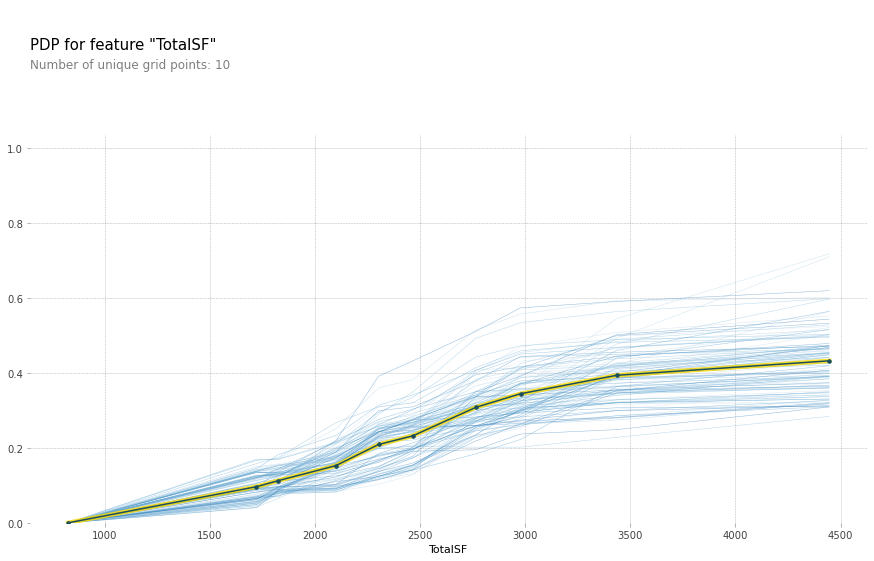

In [66]:
#generate pdpplot
plot_pdp('TotalSF', forest4, pdp_sample)

As expected, the sale price of a home increases as the total square footage of the home increases. The non-linear nature of the curve implies that once the homes reach a certain square footage, the price increase per additional square foot diminishes. This trend is also observed in the *LotArea* feature, as shown below.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f09ce601350>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f09ce6019d0>})

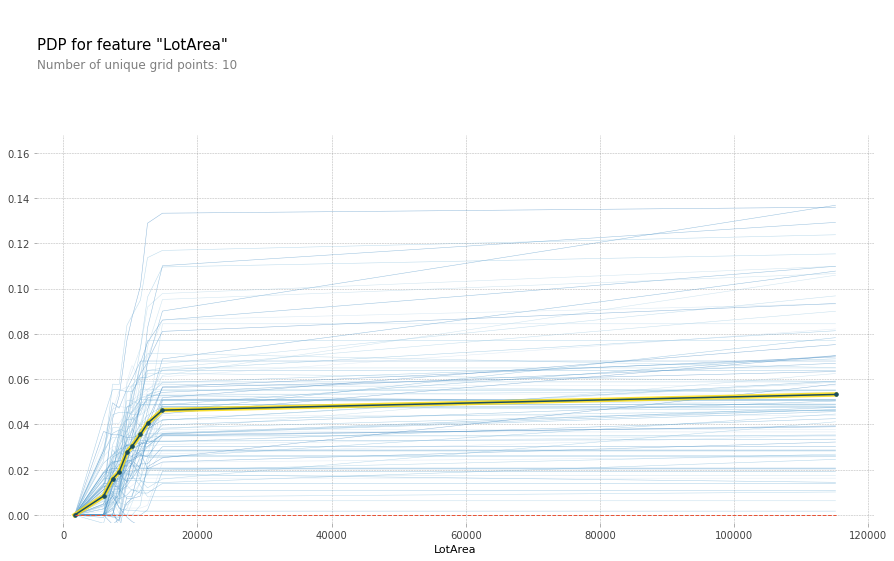

In [67]:
plot_pdp('LotArea',forest4,pdp_sample)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f09ce6c9f50>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f09ce6c9d90>})

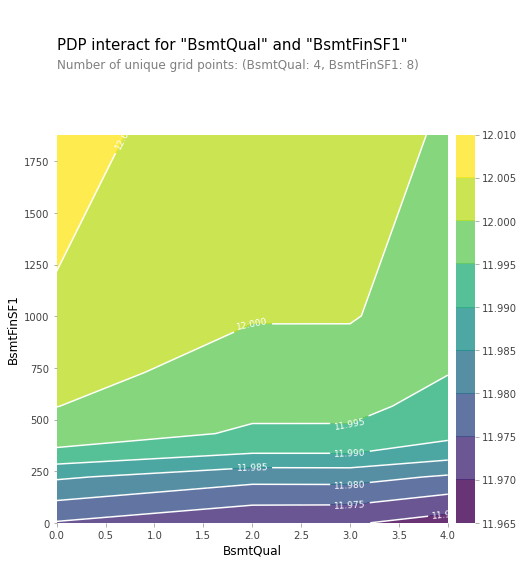

In [68]:
#get pair of features to visualize interaction
feature_pair = ['BsmtQual','BsmtFinSF1']

#generate interaction plot for feature pair
interaction = pdp.pdp_interact(forest3, pdp_sample, pdp_sample.columns, feature_pair)
pdp.pdp_interact_plot(interaction, feature_pair)

## 3.8 Tree Interpreter:
Another useful package for interpreting decision tree predictions is treeinterpreter. For all the decision points across the random forest, we can evaluate how a feature impacts the average price at that decision point. We can determine which features and which split points tend to have the largest impact on predicted price.

We will apply the tree interpreter to the first row in the validation set.

In [69]:
#get first sample in validation set
row = X_val4.values[None,0]
row

array([[6.0000e+00, 3.2350e+03, 1.9350e+03, 2.0000e+00, 5.4000e+02,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 1.9860e+03, 1.3728e+04,
        6.2600e+02, 4.0000e+00, 2.0000e+00, 7.0000e+00, 7.0000e+00,
        1.1270e+03, 1.2000e+02, 9.0000e+01, 5.0000e+00, 0.0000e+00,
        2.0000e+00, 1.1690e+03, 4.0000e+00, 5.0000e+00, 7.0000e+00,
        5.0000e+00, 0.0000e+00]])

The tree interpreter has 2 input parameters:
* 1. Model: the trained random forest.
* 2. Data: the data that the random forest will generate predictions for.

The tree interpreter has 3 output values:
* 1. Prediction: the prediction(s) generated by the random forest.
* 2. Bias: the mean of all predictions in the dataset the random forest generated predictions for.
* 3. Contribution: an array containing the average impact on RMSE of each feature each time it appears in a decision tree.

In [70]:
#use treeinterpreter to generate predictions, calculate bias, and contributions for the random forest
prediction, bias, contributions = ti.predict(forest4, row)
prediction, bias, contributions

(array([[12.16883285]]),
 array([12.01911652]),
 array([[-0.09663255,  0.22593947, -0.02713811, -0.03187982,  0.01143574,
          0.00835345, -0.03493067,  0.00319224,  0.01770994,  0.03487176,
          0.0045728 , -0.00340622,  0.00593618,  0.02232987,  0.01058231,
          0.00596062, -0.00074495, -0.01304232, -0.00421124, -0.00056846,
          0.00891955,  0.00182762,  0.00041582,  0.00047382,  0.00236128,
          0.00119147, -0.00380328]]))

In [71]:
#retrieve the indices that would sort the contributions of each feature in the random forest
idxs = np.argsort(contributions[0])
idxs

array([ 0,  6,  3,  2, 17, 18, 26, 11, 16, 19, 22, 23, 25, 21, 24,  7, 10,
       12, 15,  5, 20, 14,  4,  8, 13,  9,  1])

In [72]:
#list comprehension that zips together the feature name, feature category, and contribution of that feature for the first sample 
#in the validation set
[o for o in zip(df_keep2.columns[idxs], X_val4.iloc[0][idxs], contributions[0][idxs])]

[('OverallQual', 6.0, -0.09663255272710543),
 ('ExterQual', 3.0, -0.03493067435695933),
 ('TotalBaths', 2.0, -0.0318798224151728),
 ('YearBuilt', 1935.0, -0.027138113184194835),
 ('PorchSF', 90.0, -0.013042318296914556),
 ('BsmtFinType1', 5.0, -0.004211235398089652),
 ('MasVnrArea', 0.0, -0.003803281843624884),
 ('BsmtQual', 4.0, -0.0034062192596620465),
 ('LotFrontage', 120.0, -0.0007449474782669441),
 ('OpenPorchSF', 0.0, -0.0005684557419592285),
 ('BedroomAbvGr', 4.0, 0.0004158227850101337),
 ('GarageQual', 5.0, 0.00047381886116473206),
 ('HouseStyle', 5.0, 0.001191471165546787),
 ('Id', 1169.0, 0.0018276158017147548),
 ('MoSold', 7.0, 0.0023612778992935456),
 ('CentralAir', 1.0, 0.003192244075167405),
 ('BsmtFinSF1', 626.0, 0.004572799830325236),
 ('GarageType', 2.0, 0.005936181224505876),
 ('TotalBsmtSF', 1127.0, 0.005960617839350179),
 ('GarageCars', 2.0, 0.008353448979473876),
 ('KitchenQual', 2.0, 0.008919554690366783),
 ('Neighborhood', 7.0, 0.01058231074960161),
 ('GarageArea

The tree interpreter indicates that an *OverallQual* of 6 has the greatest negative impact on sale price on average. It also indicates that a *TotalSF* of 3235 square feet has the largest positive impact on sale price on average. This is a useful tool to help validate our findings that *TotalSF* was one of the most important predictors of sale price.

## 3.9 Hyperparameter Tuning:
We can use GridSearchCV to iterate through some hyperparameters for the random forest regressor. As seen below, the model performs best using a random forest with 500 trees, and setting the maximum features available at any decision point to 0.5 (50% of the feature set). 

In [73]:
parameters = {'n_estimators': [40, 80, 100, 150, 200, 500], 'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8]}
rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters)
clf.fit(X_train4, y_train4)
clf.best_estimator_

RandomForestRegressor(max_features=0.5, n_estimators=500)

## 3.10 Final Random Forest Model:
Using those hyperparameters, we can build our final random forest model. We can see that this our lowest RMSE value so far, a total improvement of almost 20% from our initial model.

In [74]:
forest5,preds5,error5 = train_rf_regressor(n_trees=500, min_samples_leaf=1, max_features = 0.5, \
                                           X_train=X_train4,y_train=y_train4,\
                                           X_val=X_val4, y_val=y_val4, error_type='rmse')

OoB Score: 0.8828674375484116, Validation Error (rmse): 0.12941963408584523


# 4 Testing Model:
Now we can generate predictions for the test set. Since our model is using the logarithm of the sale price, we must convert the predictions back to the true sale price. 

In [75]:
#convert predictions back to real prices with expontential function
test_preds = np.expm1(forest5.predict(X_test3))
test_preds[0:5]

array([123086.26153186, 161288.06364752, 176207.88358148, 186167.14704663,
       193347.42607648])

In [76]:
#prepare predictions of test set
submission = pd.DataFrame({'Id':X_test3.Id, 'SalePrice': test_preds})
submission.to_csv('/kaggle/working/housing_price_submission.csv', index=False, header=True)
submission.head()

,Id,SalePrice
0,1461,123086.261532
1,1462,161288.063648
2,1463,176207.883581
3,1464,186167.147047
4,1465,193347.426076


In [77]:
#ensure correct number of predictions
submission.shape

(1459, 2)